In [111]:
from sir_model import SIR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit, expit
import seaborn as sns

# Johns Hopkins data

In [112]:
main_link = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
CONFIRMED = pd.read_csv(main_link+'time_series_19-covid-Confirmed.csv')
DEATHS = pd.read_csv(main_link+'time_series_19-covid-Deaths.csv')
RECOVERED = pd.read_csv(main_link+'time_series_19-covid-Recovered.csv')

# Finnish HS data

In [113]:
import requests
import json
res = requests.get('https://w3qa5ydb4l.execute-api.eu-west-1.amazonaws.com/prod/finnishCoronaData')
finland_data = json.loads(res.content)

confirmed_finland = pd.DataFrame(finland_data['confirmed'])
deaths_finland = pd.DataFrame(finland_data['deaths'])
recovered_finland = pd.DataFrame(finland_data['recovered'])

confirmed_finland.date = pd.to_datetime(confirmed_finland.date)
confirmed_finland.date = confirmed_finland.date.dt.date

In [114]:
finland_total = confirmed_finland.groupby(['date'], as_index=False)['id'].count()

In [115]:
finland_total.tail()

,date,id
16,2020-03-16,34
17,2020-03-17,40
18,2020-03-18,42
19,2020-03-19,41
20,2020-03-20,50


In [116]:
finland_total.id.cumsum().tail()

16    277
17    317
18    359
19    400
20    450
Name: id, dtype: int64

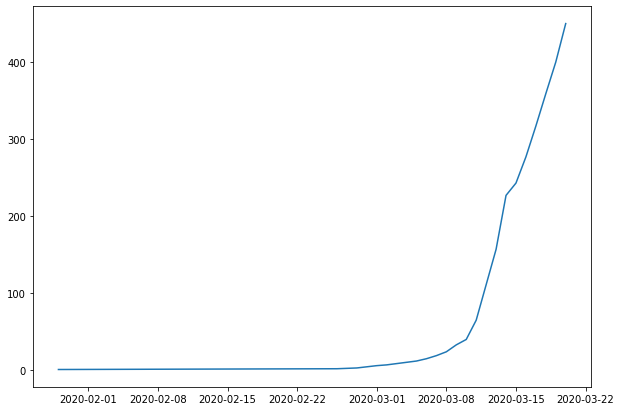

In [117]:
plt.figure(figsize=(10, 7))
plt.plot(finland_total.date, finland_total.id.cumsum())
plt.show()

In [118]:
confirmed_uusima = confirmed_finland[confirmed_finland.healthCareDistrict.isin(['HUS'])]
total_uusima = confirmed_uusima.groupby(['date'], as_index=False)['id'].count()

In [119]:
total_uusima.tail()

,date,id
15,2020-03-16,21
16,2020-03-17,32
17,2020-03-18,16
18,2020-03-19,28
19,2020-03-20,30


In [120]:
total_uusima.id.cumsum().tail()

15    148
16    180
17    196
18    224
19    254
Name: id, dtype: int64

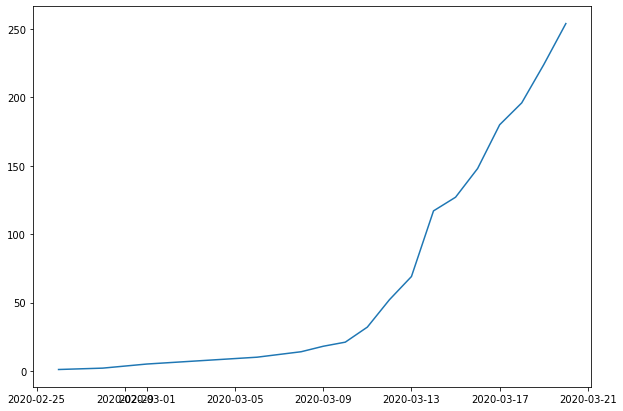

In [121]:
plt.figure(figsize=(10, 7))
plt.plot(total_uusima.date, total_uusima.id.cumsum())
plt.show()

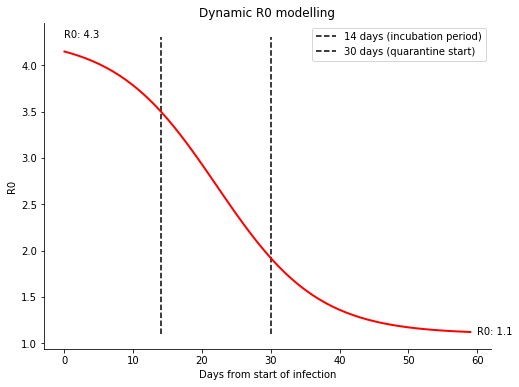

In [122]:
max_R0 = 4.3
min_R0 = 1.1

dynamic_R0 = expit(np.linspace(-5, 3, num=60))[::-1]
dynamic_R0 = dynamic_R0 * (max_R0 - min_R0) + min_R0
dynamic_R0 = np.concatenate((dynamic_R0, np.repeat(dynamic_R0[-1], 400-len(dynamic_R0))))

plt.figure(figsize=(8, 6))
plt.plot(dynamic_R0[:60], linewidth=2, color='red')
plt.title("Dynamic R0 modelling")
plt.text(0, max_R0, f"R0: {max_R0}")
plt.text(60, min_R0, f"R0: {min_R0}")
plt.vlines(14, min_R0, max_R0, label='14 days (incubation period)', linestyles='dashed')
plt.vlines(30, min_R0, max_R0, label='30 days (quarantine start)', linestyles='dashed')
plt.ylabel("R0")
plt.xlabel("Days from start of infection")
plt.legend()

sns.despine(top=True, right=True, left=False, bottom=False)

In [17]:
# sir = SIR(N=1304851, I0=1/0.05, beta=dynamic_R0 * 0.0576 * 2,  gamma=0.0576*2, days=150)
# S, I, R = sir.run()
# sir.plot_results(S, I, R)

In [18]:
# plt.figure(figsize=(10, 7))
# plt.plot(total_uusima.id.cumsum().values, label='actual reported')
# plt.plot(I[:20]/20, label='model')
# plt.title("Uusima region")
# plt.xlabel("Days from start of infection")
# plt.ylabel("Estimated reported number of cases")
# plt.legend()
# plt.grid()

In [123]:
total_uusima.id.cumsum().values

array([  1,   2,   5,   6,   9,  10,  12,  14,  18,  21,  32,  52,  69,
       117, 127, 148, 180, 196, 224, 254])

In [124]:
def calculate_dynamic_R0(max_R0, min_R0, reaction_days, simulation_days=200):    
    dynamic_R0 = expit(np.linspace(-5, 3, num=reaction_days))[::-1]
    dynamic_R0 = dynamic_R0 * (max_R0 - min_R0) + min_R0
    dynamic_R0 = np.concatenate((dynamic_R0, np.repeat(dynamic_R0[-1], simulation_days)))
    return dynamic_R0

In [125]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error

In [126]:
def loss(sir_params, actual_data):
    
    percentage_unobserved, max_R0, min_R0, reaction_days, gamma = sir_params
    
    dynamic_R0 = calculate_dynamic_R0(max_R0, min_R0, int(reaction_days), len(actual_data))
    
    sir = SIR(N=1304851, I0=1/percentage_unobserved, beta=dynamic_R0 * gamma, gamma=gamma, days=len(actual_data))
    S, I, R = sir.run()
    
    return mean_squared_error(I*percentage_unobserved, actual_data)#np.mean(np.square(I/10-actual_data))

In [127]:
loss([0.05, 6, 1, 60, 0.01], total_uusima.id.cumsum().values)

12064.366480300501

In [128]:
from scipy.optimize import minimize

In [129]:
%%time
percentage_unobserved = 0
max_R0 = 0
min_R0 = 0
reaction_days=0
gamma = 10

res = minimize(
    loss, 
    x0=[percentage_unobserved, max_R0, min_R0, reaction_days, gamma],
    args=(total_uusima.id.cumsum().values),
    #L-BFGS-B, TNC, SLSQP
    method="SLSQP",
    bounds=((0.01, 1), (2.1, 6), (1., 2.1), (15, 100), (0.0576, 0.0576*4))
)

print(res)

     fun: 438.7516486930232
     jac: array([5013.93229294, 1813.23638153, 3809.52892303,    0.        ,
       2260.93663406])
 message: 'Optimization terminated successfully.'
    nfev: 197
     nit: 21
    njev: 17
  status: 0
 success: True
       x: array([ 0.2557773 ,  2.87432912,  2.04420627, 15.        ,  0.23039998])
CPU times: user 2.43 s, sys: 0 ns, total: 2.43 s
Wall time: 2.57 s


0.2557773028247493 2.874329120666961 2.0442062661933393 15.0 0.2303999807017334


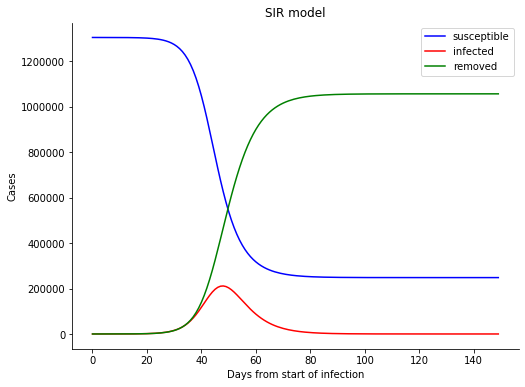

In [130]:
percentage_unobserved, max_R0, min_R0, reaction_days, gamma = res.x
print(percentage_unobserved, max_R0, min_R0, reaction_days, gamma)

sir = SIR(
    N=1304851, I0=1/percentage_unobserved, beta=calculate_dynamic_R0(max_R0, min_R0, int(reaction_days), 300)*gamma, 
    gamma=gamma, days=150)
S, I, R = sir.run()

plt.figure(figsize=(8, 6))
plt.title("SIR model")
plt.plot(S, color='b', label='susceptible')
plt.plot(I, color='r', label='infected')
plt.plot(R, color='g', label='removed')
plt.legend()
plt.xlabel("Days from start of infection")
plt.ylabel("Cases")
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [131]:
I[:20]

array([   3.90965105,    5.96685572,    9.04819294,   13.5796989 ,
         20.06520248,   29.01920244,   40.89340594,   56.09059073,
         75.10961428,   98.72883031,  128.1205397 ,  164.90108068,
        211.17887634,  269.64031917,  343.68451354,  437.60891377,
        557.15973619,  709.30295025,  902.88190481, 1149.1133684 ])

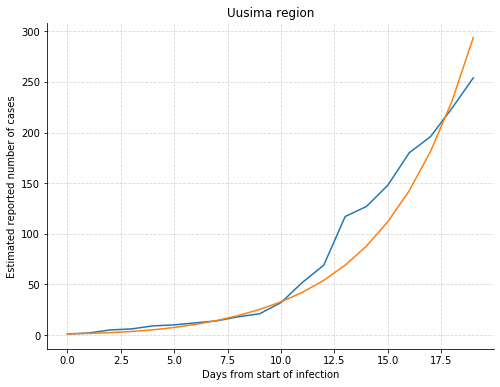

In [134]:
plt.figure(figsize=(8, 6))
plt.plot(total_uusima.id.cumsum().values)
plt.plot(I[:20]*percentage_unobserved)
plt.title("Uusima region")
plt.xlabel("Days from start of infection")
plt.ylabel("Estimated reported number of cases")
sns.despine(top=True, right=True, left=False, bottom=False)
plt.grid(alpha=0.5, linestyle='dashed')